In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Считываем данные 

In [1]:
# исторические данные 
df_base = pd.read_csv(r"\Cohort.csv", index_col=False)
df_base = df_base.drop(df_base.columns[1],axis = 1)

# новые данные 
dfC52023 = pd.read_csv(r"\UAC52023.csv", index_col=False)
dfC102023 = pd.read_csv(r"\UAC102023.csv", index_col=False)

# объединяем и удаляем дупликаты
df = pd.concat([df_base, dfC52023, dfC102023],  ignore_index = True)
df = df.drop_duplicates(subset=["Campaign", "Consultant num", "Member type"])

df = df.drop(df.columns[0],axis = 1)
df = df.dropna(axis=0)
print(df.Campaign.max())

display(df.head())
print(df.info())

NameError: name 'pd' is not defined

In [2]:
# фильтруем по типу партнера 
df = df[df['Member type'] == 'VIP/CUSTOMER']
# df = df[df['Member type'] == 'BRAND PARTNER']

print(df.info())

NameError: name 'df' is not defined

#### Когортный анализ

In [3]:
# создаем копию
data = df.copy()

NameError: name 'df' is not defined

In [4]:
# создаем новый столбец который обозгачет компанию в который бренд партнер соврешает заказ
data['OrderPeriod'] = data.Campaign.apply(lambda x: x)
data.head()
data.set_index('Consultant num', inplace=True) #добавим индекс в dataFrame по ClientID
display(data.head())
data['JoinCamp'] = data.groupby(level=0)['Campaign'].min().apply(lambda x: x)  #добавим столбец 'JoinCamp'
# столбец обозначает дату первого соверешния заказа консултантом (когорта)

NameError: name 'data' is not defined

#### Оставляем только рекрутов

In [84]:
# Оставляем только рекрутов в когорте "убрать если необохдим анализ по всем бренд партнерам"
data = data.drop(data[(data['OrderPeriod'] == data['JoinCamp'])&(data['Is_recruit'] == 0)].index)

In [85]:
data.reset_index(inplace=True) #переиндексируем df

In [6]:
data.insert(len(data.columns), "TotalOrders", 0, allow_duplicates=False) #создадим столбец в котором далее поместим количество заказов
data.head()

NameError: name 'data' is not defined

In [87]:
# группируем по когорте и соврешению даействий
grouped = data.groupby(['JoinCamp', 'OrderPeriod'])
display(grouped)

# количество уникальных пользователей и общее количество заказов и выручка за период
cohorts = grouped.agg({'Consultant num': pd.Series.nunique,
 'TotalOrders': pd.Series.count, 
 'BP': np.sum})
# переименуем некоторые столбцы для большей наглядности
cohorts.rename(columns={'Consultant num' : 'TotalUsers'}, inplace=True)

# посчитам дополнительные метрики
cohorts['ARPU'] = (cohorts['BP'] / cohorts['TotalUsers']).astype(int)
cohorts['ARPU Opening'] =(cohorts['BP']  / cohorts.groupby(['JoinCamp'])['TotalUsers'].max()).astype(int)
cohorts.head()

TotalUsers  TotalOrders       BP  ARPU  ARPU Opening
JoinCamp OrderPeriod                                                      
2021-C09 2021-C09           2313         2313  64364.0    27            27
         2021-C10            595          595  23539.0    39            10
         2021-C11            478          478  17223.0    36             7
         2021-C12            437          437  14853.0    33             6
         2021-C13            571          571  16296.0    28             7

In [88]:

# введем функцию для рачссчета периодов от начала кагорты 
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1 # отсчет с 1
    return df
cohorts = cohorts.groupby(level=0).apply(cohort_period)

# меняем тип данных на удобный
cohorts['BP'] = cohorts['BP'].astype(int)
cohorts.head(40)

TotalUsers  TotalOrders      BP  ARPU  ARPU Opening  \
JoinCamp OrderPeriod                                                        
2021-C09 2021-C09           2313         2313   64364    27            27   
         2021-C10            595          595   23539    39            10   
         2021-C11            478          478   17223    36             7   
         2021-C12            437          437   14853    33             6   
         2021-C13            571          571   16296    28             7   
         2021-C14            376          376   12604    33             5   
         2021-C15            367          367   13194    35             5   
         2021-C16            317          317   11773    37             5   
         2021-C17            295          295   10600    35             4   
         2021-C18            233          233    8319    35             3   
         2022-C01            260          260    8135    31             3   
         2022-C02            238          238    7790    32             3   
         2022-C03             61           61    2195    35             0   
         2022-C05              1            1      58    58             0   
         2022-C06             52           52    4707    90             2   
         2022-C07             76           76    7953   104             3   
         2022-C08             42           42    5986   142             2   
         2022-C09             72           72    5045    70             2   
         2022-C10             71           71    5899    83             2   
         2022-C11             90           90    7911    87             3   
         2022-C12             79           79    3166    40             1   
         2022-C13             79           79    3262    41             1   
         2022-C14             87           87    3091    35             1   
         2022-C15             70           70    3042    43             1   
         2022-C16             63           63    3050    48             1   
         2022-C17             65           65    2831    43             1   
         2022-C18             84           84    3406    40             1   
         2023-C01             69           69    2725    39             1   
         2023-C02             69           69    3235    46             1   
         2023-C03             78           78    3361    43             1   
         2023-C04             66           66    2691    40             1   
         2023-C05             55           55    2884    52             1   
         2023-C06             55           55    2297    41             0   
         2023-C07             46           46    2206    47             0   
         2023-C08             49           49    2734    55             1   
         2023-C09             48           48    1957    40             0   
         2023-C10             10           10     346    34             0   
2021-C10 2021-C10           6129         6129  127006    20            20   
         2021-C11           1165         1165   40458    34             6   
         2021-C12            735          735   22784    30             3   

                      CohortPeriod  
JoinCamp OrderPeriod                
2021-C09 2021-C09                1  
         2021-C10                2  
         2021-C11                3  
         2021-C12                4  
         2021-C13                5  
         2021-C14                6  
         2021-C15                7  
         2021-C16                8  
         2021-C17                9  
         2021-C18               10  
         2022-C01               11  
         2022-C02               12  
         2022-C03               13  
         2022-C05               14  
         2022-C06               15  
         2022-C07               16  
         2022-C08               17  
         2022-C09               18  
         2022-C10               19  
         2

#### Проверка ошибок

In [89]:
x = data[(data.JoinCamp == '2023-C01') & (data.Campaign == '2023-C01')]
y = cohorts.loc[('2023-C01', '2023-C01')]
assert(x['Consultant num'].nunique() == y['TotalUsers'])
assert(x['BP'].sum() == y['BP'])


##### Построение когортной матрицы

In [90]:
# переиндексируем DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortPeriod','JoinCamp'], inplace=True)
# создадим ряд содержаший размер каждой когорты JoinMonth
cohort_group_size = cohorts['TotalUsers'].groupby(level=1).first()
cohort_group_size.head()

JoinCamp
2021-C09     2313
2021-C10     6129
2021-C11    10117
2021-C12     3840
2021-C13     4386
Name: TotalUsers, dtype: int64

In [91]:
cohorts['TotalUsers'].unstack(0).head(15)

CohortPeriod,1,2,3,4,5,6,7,8,9,10,...,28,29,30,31,32,33,34,35,36,37
JoinCamp,,,,,,,,,,,,,,,,,,,,,
2021-C09,2313.0,595.0,478.0,437.0,571.0,376.0,367.0,317.0,295.0,233.0,...,69.0,69.0,78.0,66.0,55.0,55.0,46.0,49.0,48.0,10.0
2021-C10,6129.0,1165.0,735.0,785.0,964.0,719.0,577.0,508.0,390.0,444.0,...,90.0,99.0,94.0,60.0,57.0,50.0,49.0,40.0,12.0,NaN
2021-C11,10117.0,1531.0,1137.0,965.0,1291.0,957.0,666.0,504.0,667.0,570.0,...,130.0,129.0,80.0,89.0,70.0,60.0,68.0,9.0,NaN,NaN
2021-C12,3840.0,775.0,540.0,471.0,575.0,443.0,291.0,318.0,321.0,67.0,...,88.0,48.0,59.0,48.0,38.0,42.0,11.0,NaN,NaN,NaN
2021-C13,4386.0,960.0,642.0,591.0,725.0,446.0,450.0,383.0,66.0,2.0,...,54.0,53.0,58.0,45.0,39.0,6.0,NaN,NaN,NaN,NaN
2021-C14,3995.0,954.0,632.0,571.0,487.0,563.0,376.0,73.0,51.0,96.0,...,44.0,50.0,39.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-C15,3269.0,890.0,641.0,363.0,605.0,420.0,62.0,3.0,50.0,91.0,...,36.0,34.0,33.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-C16,2910.0,604.0,342.0,347.0,405.0,63.0,41.0,78.0,41.0,59.0,...,30.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-C17,4053.0,700.0,568.0,508.0,98.0,3.0,63.0,110.0,59.0,64.0,...,50.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### User retention

In [92]:
# переиндексируем DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['JoinCamp','CohortPeriod'], inplace=True) #транспонировали, просто поменяв местами JoinMonth и CohortPeriod и далее добавим axis=1
# создадим ряд содержаший размер каждой когорты JoinMonth
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohorts['TotalUsers'].unstack(0)
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)

#### Users ARPU

In [93]:
# переиндексируем DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['JoinCamp','CohortPeriod'], inplace=True) #транспонировали, просто поменяв местами JoinMonth и CohortPeriod и далее добавим axis=1
# создадим ряд содержаший размер каждой когорты JoinMonth
cohorts['ARPU'].unstack(0)
cohorts_arpu = cohorts['ARPU'].unstack(0)

#### Users ARPU Opening

In [94]:
# переиндексируем DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['JoinCamp','CohortPeriod'], inplace=True) #транспонировали, просто поменяв местами JoinMonth и CohortPeriod и далее добавим axis=1
# создадим ряд содержаший размер каждой когорты JoinMonth
cohorts['ARPU Opening'].unstack(0)
cohorts_arpu_opening = cohorts['ARPU Opening'].unstack(0)

#### Users Revenue

In [95]:
# переиндексируем DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['JoinCamp','CohortPeriod'], inplace=True) #транспонировали, просто поменяв местами JoinMonth и CohortPeriod и далее добавим axis=1
# создадим ряд содержаший размер каждой когорты JoinMonth
cohorts['BP'].unstack(0)
cohorts_revenue = cohorts['BP'].unstack(0)

#### Retention rate visualization

In [96]:
cohorts['TotalUsers'].unstack(0).T.to_excel(r"Cohorts.xlsx")

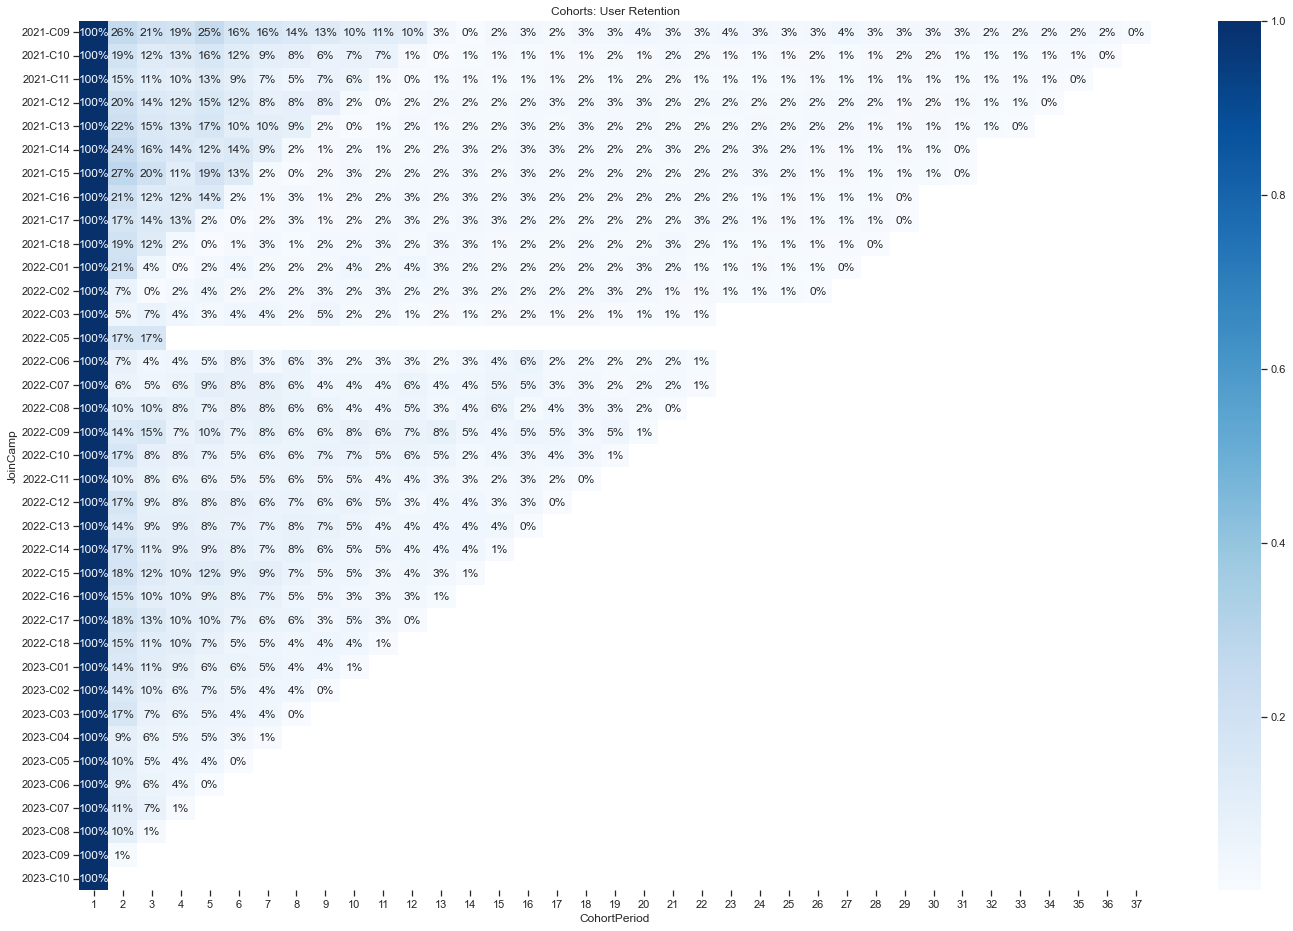

In [97]:
user_retention = user_retention.iloc[:, :] # если нужно убрать первую компанию поставив индекс [:, 1:]
import seaborn as sns
sns.set(style='ticks')
plt.figure(figsize=(24, 16))
plt.title('Cohorts: User Retention')
fig = sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), cmap='Blues' ,annot=True, fmt='.0%')
fig.figure.savefig(r"\Retention.png")
user_retention.T.to_excel(r"Retention.xlsx")


#### ARPU visualization

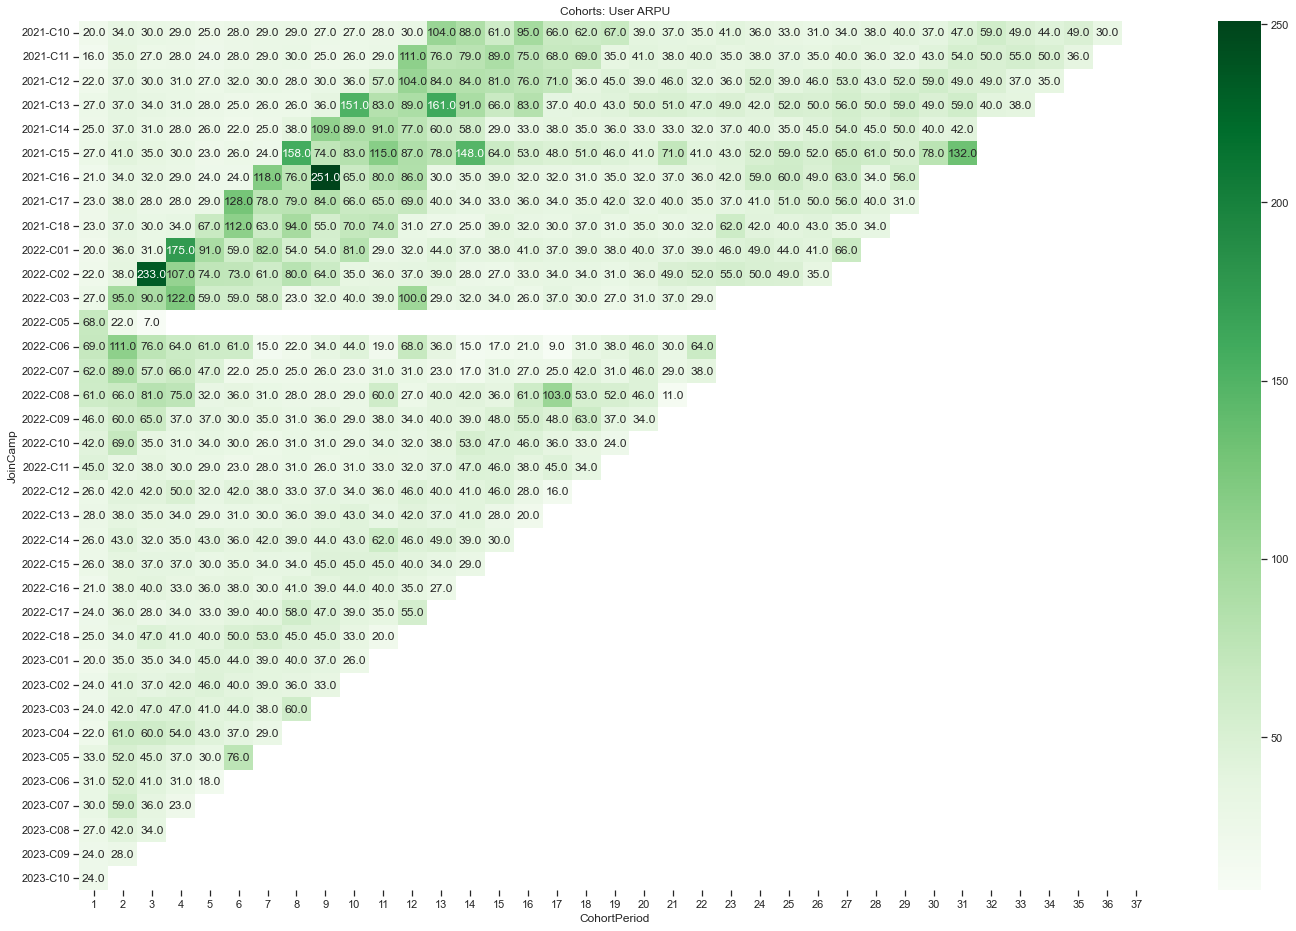

In [99]:
cohorts_arpu = cohorts_arpu.iloc[:, 1:]
import seaborn as sns
sns.set(style='ticks')
plt.figure(figsize=(24, 16))
plt.title('Cohorts: User ARPU')
fig = sns.heatmap(cohorts_arpu.T, mask=cohorts_arpu.T.isnull(), cmap='Greens', annot=True, fmt='')

